## Bias-Variance Trade-off and Cross Validation

### Introduction

One of the fundamental challenges in machine learning is the **bias-variance trade-off**. Understanding this concept is crucial for building models that generalize well to unseen data.

### What is the Bias-Variance Trade-off?

When we train a machine learning model, the total error can be decomposed into three components:

**Total Error = Bias² + Variance + Irreducible Error**

- **Bias**: Error from erroneous assumptions in the learning algorithm. High bias causes the model to miss relevant relations between features and target outputs (**underfitting**).
- **Variance**: Error from sensitivity to small fluctuations in the training set. High variance causes the model to model the random noise in the training data (**overfitting**).
- **Irreducible Error**: Error that cannot be reduced regardless of the model (inherent noise in the data).

In practice, these concepts manifest themselves usually in either underfitting or overfitting.

### Underfitting (High Bias)

**Underfitting** occurs when a model is too simple to capture the underlying patterns in the data:
- Model has **high bias** and **low variance**
- Poor performance on both training and validation data
- Example: Using a linear model for non-linear data

### Overfitting (High Variance)

**Overfitting** occurs when a model is too complex and learns the noise in the training data:
- Model has **low bias** and **high variance**
- Excellent performance on training data but poor on validation data
- Example: Using a very high-degree polynomial for simple patterns

### The Sweet Spot

The goal is to find the optimal model complexity that balances bias and variance, minimizing the total error on unseen data.

### Cross Validation

**Cross validation (CV)** is a statistical technique used to assess model performance and detect overfitting/underfitting.
The common CV steps are:
1. Partition data into training and validation subsets
2. Train model on training subset
3. Evaluate model on validation subset
4. Repeat steps 2-3 across multiple partitions
5. Aggregate results to get a reliable estimate of generalization performance


We'll use the **Auto MPG dataset** to demonstrate these concepts by:
1. Fitting polynomial models of increasing complexity (orders 1 through 7)
2. Evaluating RMSE (Root Mean Squared Error) on both training and validation sets
3. Visualizing how model complexity affects bias and variance
4. Understanding when underfitting and overfitting occur

In [1]:
# Import necessary libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

# Set up plotting aesthetics for better visualization
sns.set_context("notebook", font_scale=1.5)
sns.set_style("whitegrid", {"grid.linestyle": "--"})
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 16

In [2]:
def fit_polynomial(X: np.ndarray, y: np.ndarray, order: int = 1) -> Pipeline:
    """Fits a polynomial regression model with proper scaling.

    Args:
        X (np.ndarray): Input feature array.
        y (np.ndarray): Target values.
        order (int): Polynomial order. Defaults to 1.

    Returns:
        Pipeline: Trained pipeline with scaler, polynomial features, and model.
    """
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=order, include_bias=False)),
        ("model", LinearRegression())
    ])

    pipeline.fit(X.reshape(-1, 1), y)
    return pipeline

def plot_model_fit(
    model: Pipeline,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_validation: np.ndarray,
    y_validation: np.ndarray,
    order: int,
    ax: plt.Axes | None = None,
    title: str | None = None
) -> plt.Axes:
    """Visualizes model fit on training and validation data.

    Creates a scatter plot of training and validation data with the fitted
    model curve overlaid. Uses color coding and transparency for clarity.

    Args:
        model (Pipeline): Trained sklearn Pipeline with polynomial features.
        X_train (np.ndarray): Training feature values (1D).
        y_train (np.ndarray): Training target values.
        X_validation (np.ndarray): Validation feature values (1D).
        y_validation (np.ndarray): Validation target values.
        order (int): Polynomial order of the model.
        ax (plt.Axes, optional): Matplotlib axes to plot on. If None, creates new figure.
        title (str, optional): Custom title. If None, generates default title.

    Returns:
        plt.Axes: The axes object with the plot.
    """
    # Create figure if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 7))

    # ===== Plot Training Data =====
    ax.scatter(
        X_train,
        y_train,
        alpha=0.6,
        s=80,
        color="#2E86AB",
        label="Training Data",
        edgecolors="white",
        linewidth=1.5,
        zorder=3
    )

    # ===== Plot Validation Data =====
    ax.scatter(
        X_validation,
        y_validation,
        alpha=0.6,
        s=100,
        color="#E63946",
        marker="^",
        label="Validation Data",
        edgecolors="white",
        linewidth=1.5,
        zorder=3
    )

    # ===== Generate Smooth Curve for Model =====
    # Create dense points across the feature range for smooth curve
    X_min = min(X_train.min(), X_validation.min())
    X_max = max(X_train.max(), X_validation.max())
    X_range = X_max - X_min
    X_smooth = np.linspace(X_min - 0.05 * X_range, X_max + 0.05 * X_range, 500)

    # Get model predictions
    y_smooth = model.predict(X_smooth.reshape(-1, 1))

    # Plot the fitted curve
    ax.plot(
        X_smooth,
        y_smooth,
        color="#06A77D",
        linewidth=3.5,
        label=f"Fitted Model (Order {order})",
        zorder=4,
        alpha=0.9
    )

    # ===== Calculate and Display Metrics =====
    y_pred_train = model.predict(X_train.reshape(-1, 1))
    y_pred_validation = model.predict(X_validation.reshape(-1, 1))

    train_rmse = root_mean_squared_error(y_train, y_pred_train)
    val_rmse = root_mean_squared_error(y_validation, y_pred_validation)

    # Add text box with metrics
    textstr = f"Train RMSE: {train_rmse:.2f}\nVal RMSE: {val_rmse:.2f}"
    props = dict(boxstyle="round,pad=0.5", facecolor="wheat", alpha=0.8)
    ax.text(
        0.05, 0.95, textstr,
        transform=ax.transAxes,
        fontsize=11,
        verticalalignment="top",
        bbox=props
    )

    # ===== Styling =====
    ax.set_xlabel("Horsepower", fontsize=13, weight="bold")
    ax.set_ylabel("MPG (Miles Per Gallon)", fontsize=13, weight="bold")

    if title is None:
        title = f"Polynomial Regression (Order {order})"
    ax.set_title(title, fontsize=14, weight="bold", pad=15)

    ax.legend(fontsize=10, loc="upper right", frameon=True, shadow=True, fancybox=True)
    ax.grid(True, alpha=0.3, linestyle="--", linewidth=0.7)

    # Set reasonable y-limits
    y_min = min(y_train.min(), y_validation.min(), y_smooth.min())
    y_max = max(y_train.max(), y_validation.max(), y_smooth.max())
    y_range = y_max - y_min
    ax.set_ylim(y_min - 0.05 * y_range, y_max + 0.05 * y_range)

    return ax

# Load the Auto MPG dataset
# This dataset contains fuel consumption data for various cars
auto = pd.read_csv(
    "https://raw.githubusercontent.com/changyaochen/"
    "MECE4520/master/data/auto_mpg.csv"
)

# Remove any rows with missing values
auto.dropna(inplace=True)

print(f"The shape of the data is {auto.shape}")
print(f"We have {auto.shape[0]} cars and {auto.shape[1]} features")
auto.head()

The shape of the data is (392, 9)
We have 392 cars and 9 features


,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino


### Visualizing Model Complexity vs. Performance

Now let's visualize how model complexity, in this case, polynomial order of the single feature, 
affects training and validation error. This is the key to understanding the bias-variance trade-off.

In the following, we will first split the data into training and validation sets, 
then we will train `k` polynomial models with different orders
up to  `max_order` (default to 8). For each model, we will calculate the training and validation errors.

On top of that, we will repeat the above process for `n_trials` times to see the variance of the errors.
For each trial, we will use a different random split of the data into training and validation sets.

**What to look for:**
- **Training error** (blue line): Shows how well the model fits the training data. It should be decreasing as the polynomial order increases.
- **Validation error** (orange line): Shows how well the model generalizes to unseen data. As the polynomial order increases, the validation error should decrease initially, but then increase.

Training models with different polynomial orders...
Running 200 trials with orders 1 through 9


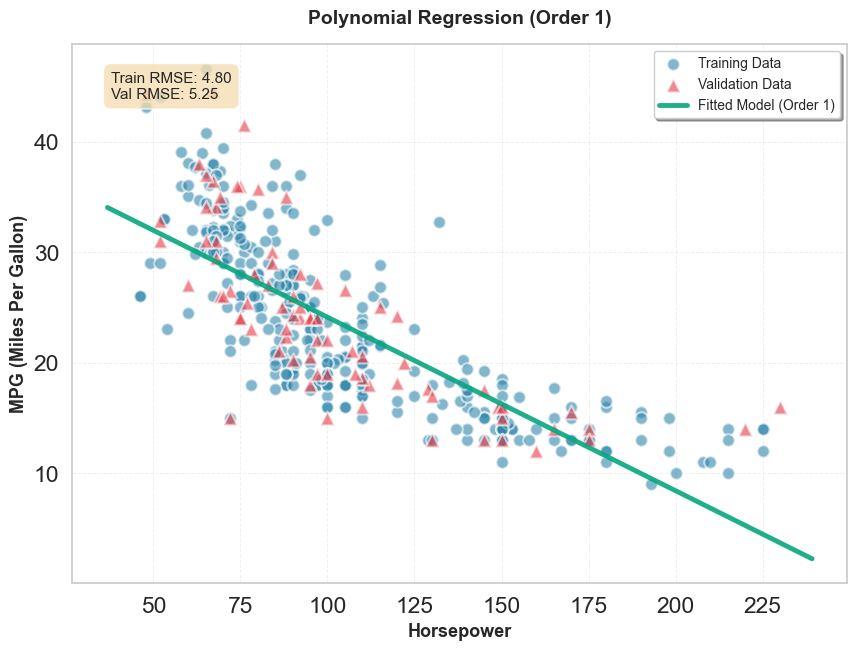

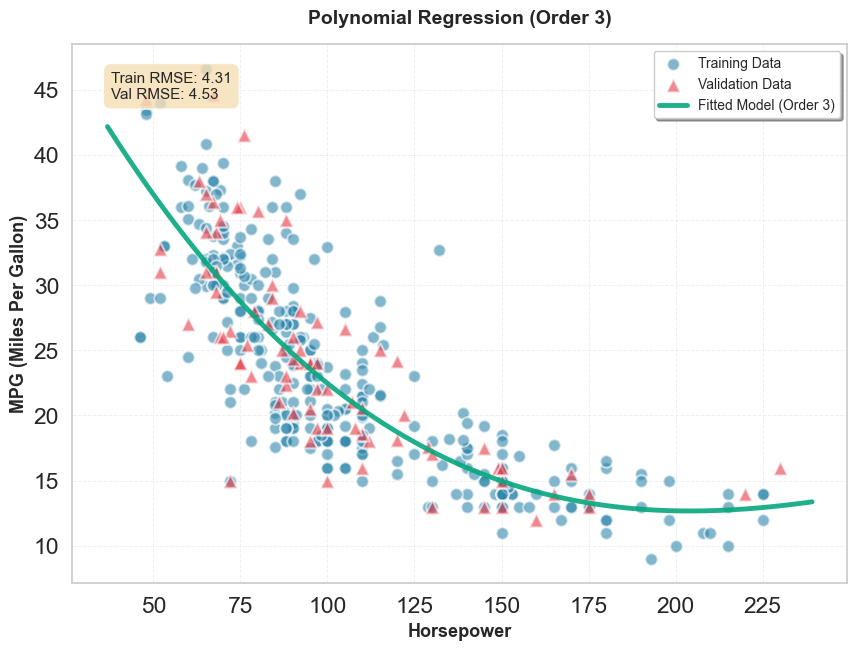

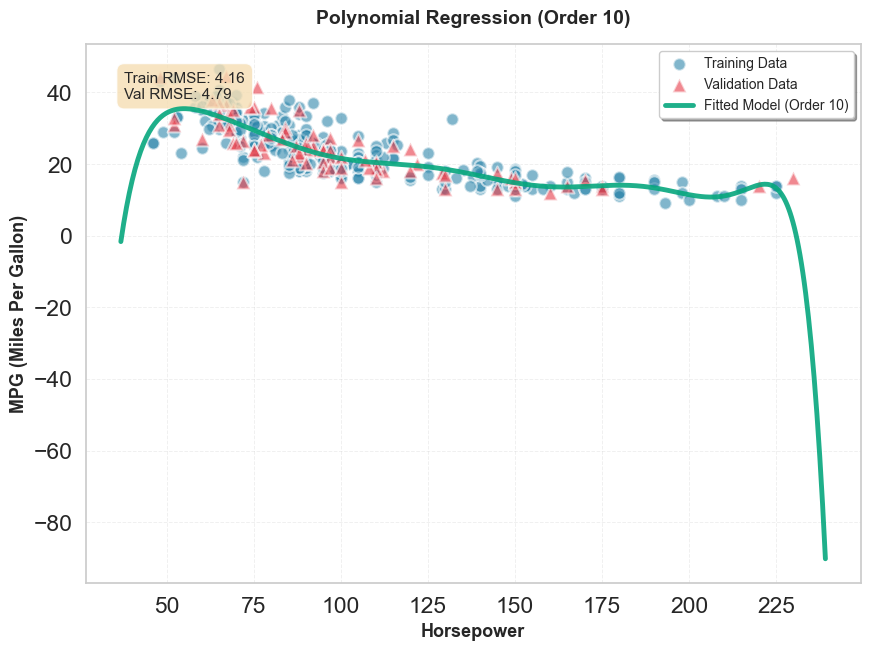

In [12]:
# Extract features and target
X = auto["horsepower"].values
y = auto["mpg"].values

# Experimental setup
n_trials = 200  # Run multiple trials to assess variance across different train/test splits
max_order = 10  # Max order to test

# Initialize list to collect RMSE results from all trials
# We'll convert this to a DataFrame later
rmse_records: list[dict] = []

print("Training models with different polynomial orders...")
print(f"Running {n_trials} trials with orders 1 through {max_order - 1}")

# Loop through multiple trials with different random splits
for t in range(n_trials):
    # Split data into 80% training and 20% validation
    # Different random_state ensures different splits across trials
    X_train, X_validation, y_train, y_validation = train_test_split(
        X, y, test_size=0.2, random_state=(98 + t)
    )

    # Test polynomial models of increasing complexity
    for order in range(1, max_order + 1):
        model = fit_polynomial(X_train, y_train, order)

        # Make predictions on training data
        y_pred_train = model.predict(X_train.reshape(-1, 1))

        # Make predictions on validation data (unseen during training)
        y_pred_validation = model.predict(X_validation.reshape(-1, 1))

        # Calculate RMSE for both sets
        # Lower RMSE = better predictions
        train_rmse = root_mean_squared_error(
            y_true=y_train, y_pred=y_pred_train
        )
        validation_rmse = root_mean_squared_error(
            y_true=y_validation, y_pred=y_pred_validation
        )

        # Store results
        rmse_records.append({
            "trial_index": t,
            "order": order,
            "train": train_rmse,
            "validation": validation_rmse,
        })

        if t == 0 and order in (1, 3, max_order):
            plot_model_fit(
                model=model,
                X_train=X_train,
                y_train=y_train,
                X_validation=X_validation,
                y_validation=y_validation,
                order=order
            )

# Convert collected records to DataFrame
rmse = pd.DataFrame(rmse_records)

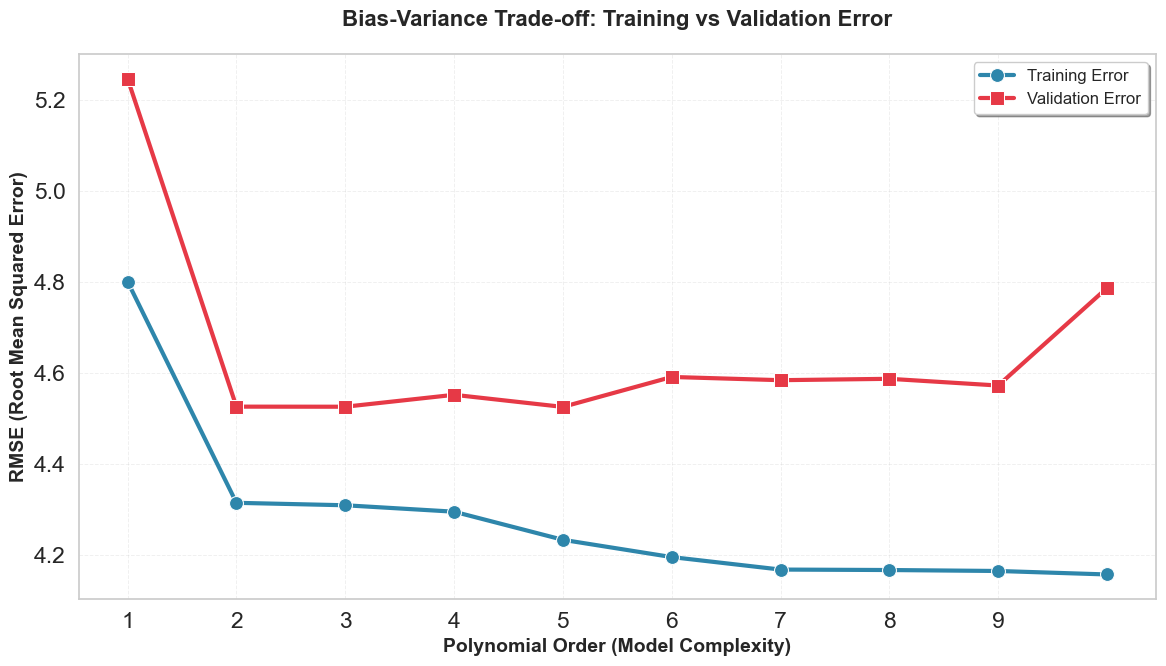

In [4]:
# ============================================================================
# Visualize Bias-Variance Trade-off
# ============================================================================

# Select one trial to visualize the trend
trial_index = 0
trial_data = rmse[rmse["trial_index"] == trial_index]

# Create figure with better aesthetics
fig, ax = plt.subplots(figsize=(12, 7))

# Plot training and validation errors with distinct colors
sns.lineplot(
    x="order",
    y="train",
    data=trial_data,
    label="Training Error",
    marker="o",
    markersize=10,
    linewidth=3,
    color="#2E86AB",  # Blue
    ax=ax
)

sns.lineplot(
    x="order",
    y="validation",
    data=trial_data,
    label="Validation Error",
    marker="s",
    markersize=10,
    linewidth=3,
    color="#E63946",  # Red
    ax=ax
)

# Enhance labels and title
ax.set_xlabel("Polynomial Order (Model Complexity)", fontsize=14, weight="bold")
ax.set_ylabel("RMSE (Root Mean Squared Error)", fontsize=14, weight="bold")
ax.set_title(
    "Bias-Variance Trade-off: Training vs Validation Error",
    fontsize=16,
    weight="bold",
    pad=20
)

# Improve legend
ax.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)

# Set x-axis to show integer values only
ax.set_xticks(range(1, max_order))

# Add grid for better readability
ax.grid(True, alpha=0.3, linestyle="--", linewidth=0.7)

plt.tight_layout()
plt.show()

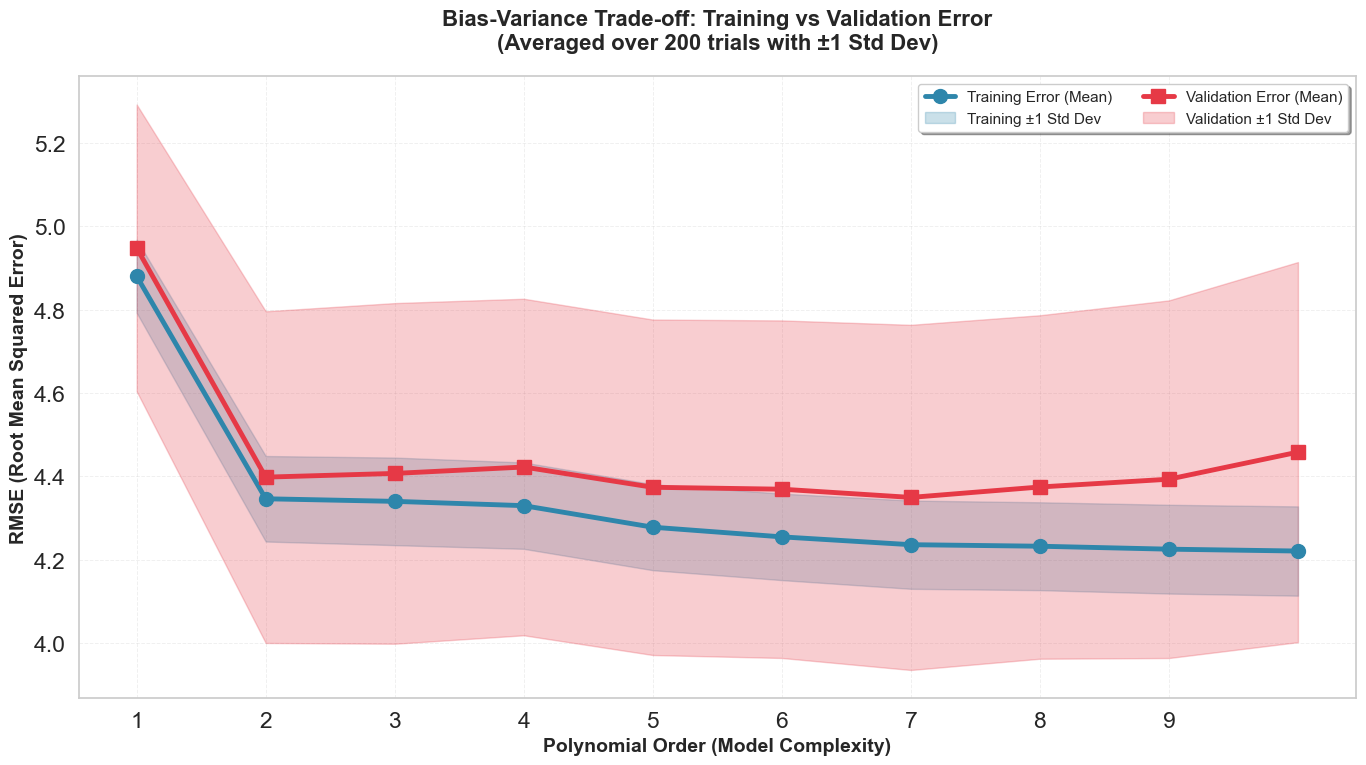


📈 Statistical Summary:

Order    Train Mean   Train Std    Val Mean     Val Std      Gap         
--------------------------------------------------------------------------------
1        4.880        0.088        4.948        0.344        0.068       
2        4.346        0.103        4.398        0.398        0.052       
3        4.340        0.105        4.407        0.409        0.067       
4        4.329        0.104        4.422        0.404        0.093       
5        4.278        0.103        4.373        0.403        0.096       
6        4.254        0.104        4.369        0.405        0.114       
7        4.236        0.106        4.349        0.414        0.114       
8        4.232        0.106        4.374        0.412        0.142       
9        4.225        0.107        4.393        0.429        0.168       


In [5]:
# ============================================================================
# Visualize Training and Validation Error with Confidence Intervals
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 8))

# Calculate mean and standard deviation for both training and validation
train_stats = rmse.groupby("order")["train"].agg(["mean", "std"])
validation_stats = rmse.groupby("order")["validation"].agg(["mean", "std"])

# ===== Plot Training Error =====
# Plot mean line
ax.plot(
    train_stats.index,
    train_stats["mean"],
    color="#2E86AB",
    linewidth=3.5,
    marker="o",
    markersize=10,
    label="Training Error (Mean)",
    zorder=3
)

# Add shaded confidence interval (mean ± 1 std)
ax.fill_between(
    train_stats.index,
    train_stats["mean"] - train_stats["std"],
    train_stats["mean"] + train_stats["std"],
    alpha=0.25,
    color="#2E86AB",
    label="Training ±1 Std Dev"
)

# ===== Plot Validation Error =====
# Plot mean line
ax.plot(
    validation_stats.index,
    validation_stats["mean"],
    color="#E63946",
    linewidth=3.5,
    marker="s",
    markersize=10,
    label="Validation Error (Mean)",
    zorder=3
)

# Add shaded confidence interval (mean ± 1 std)
ax.fill_between(
    validation_stats.index,
    validation_stats["mean"] - validation_stats["std"],
    validation_stats["mean"] + validation_stats["std"],
    alpha=0.25,
    color="#E63946",
    label="Validation ±1 Std Dev"
)


# ===== Enhance Labels and Styling =====
ax.set_xlabel("Polynomial Order (Model Complexity)", fontsize=14, weight="bold")
ax.set_ylabel("RMSE (Root Mean Squared Error)", fontsize=14, weight="bold")
ax.set_title(
    f"Bias-Variance Trade-off: Training vs Validation Error\n(Averaged over {n_trials} trials with ±1 Std Dev)",
    fontsize=16,
    weight="bold",
    pad=20
)
ax.legend(fontsize=11, loc="upper right", frameon=True, shadow=True, ncol=2)
ax.grid(True, alpha=0.3, linestyle="--", linewidth=0.7)
ax.set_xticks(range(1, max_order))

plt.tight_layout()
plt.show()

# ===== Print Statistical Summary =====
print(f"\n📈 Statistical Summary:")
print(f"\n{'Order':<8} {'Train Mean':<12} {'Train Std':<12} {'Val Mean':<12} {'Val Std':<12} {'Gap':<12}")
print("-" * 80)
for order in range(1, max_order):
    train_mean = train_stats.loc[order, "mean"]
    train_std = train_stats.loc[order, "std"]
    val_mean = validation_stats.loc[order, "mean"]
    val_std = validation_stats.loc[order, "std"]
    gap = val_mean - train_mean  # Gap between validation and training error
    print(f"{order:<8} {train_mean:<12.3f} {train_std:<12.3f} {val_mean:<12.3f} {val_std:<12.3f} {gap:<12.3f}")


## Solutions to Overfitting and Underfitting

### Dealing with Underfitting (High Bias)

When your model is too simple and shows high error on both training and validation sets:

**Solutions:**
1. **Increase model complexity**: Use more features, higher polynomial orders, or more complex model architectures
2. **Add more features**: Include additional relevant variables or create interaction terms
3. **Reduce regularization**: If using regularization, decrease the regularization strength
4. **Train longer**: Increase the number of training iterations/epochs

### Dealing with Overfitting (High Variance)

When your model performs well on training data but poorly on validation data:

**Solutions:**
1. **Collect more training data**: More data helps the model learn true patterns vs noise
2. **Reduce model complexity**: Use simpler models, lower polynomial orders, or fewer features
3. **Use regularization**: Apply L1 (Lasso), L2 (Ridge), or elastic net regularization
4. **Cross-validation**: Use k-fold cross-validation for more robust performance estimates
5. **Early stopping**: Stop training when validation error starts increasing
6. **Dropout**: For neural networks, randomly drop connections during training
7. **Feature selection**: Remove irrelevant or redundant features
8. **Ensemble methods**: Use techniques like random forests or boosting

### The Role of Cross-Validation

Cross-validation helps us:
- **Detect overfitting/underfitting** early in model development
- **Select optimal model complexity** (hyperparameter tuning)
- **Get reliable performance estimates** by averaging across multiple splits
- **Make better use of limited data** by using all data for both training and validation

### Key Takeaways

1. **Bias-variance trade-off is fundamental**: All models must balance these two sources of error
2. **Simple models underfit**: They have high bias and miss important patterns
3. **Complex models overfit**: They have high variance and learn noise
4. **Validation is critical**: Always evaluate on data the model hasn't seen
5. **There's no free lunch**: The optimal model complexity depends on your specific dataset and problem

### Next Steps

In practice, you would:
1. Start with a simple model (baseline)
2. Gradually increase complexity while monitoring validation performance
3. Use cross-validation to select optimal hyperparameters
4. Test final model on a held-out test set
5. Consider ensemble methods to further improve generalization
